# scenarios

In [1]:
from real_map import RealMap
from demands import DemandGenerator
from order_info import OrderGenerator
import random
import pandas as pd
import numpy as np

In [2]:
 # Set random seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Create RealMap instance
realMap = RealMap(n_r=2, n_c=4, dist_function=np.random.uniform, dist_params={'low': -1, 'high': 1})

# Generate demands
random_params = {
    'sample_dist': {'function': np.random.randint, 'params': {'low': 1, 'high': 3}},
    'demand_dist': {'function': np.random.poisson, 'params': {'lam': 2}}
    }
demands = DemandGenerator(time_range=30, time_step=10, restaurants=realMap.restaurants,
                         customers=realMap.customers, random_params=random_params)

# Create PDPTWInstance
time_params = {'time_window_length': 30, 'service_time': 5, 'extra_time': 10}
pdptw_order = OrderGenerator(realMap, demands.demand_table, time_params, robot_speed=4)

# Generate and display the whole table
df = pdptw_order.order_table
print('Total number of orders:', pdptw_order.total_number_orders)
pd.set_option('display.max_columns', None)
df

Total number of orders: 8


,ID,Type,X,Y,Demand,StartTime,EndTime,ServiceTime,PartnerID,RealIndex,RealType
0,0,depot,-0.250920,0.901429,0,0.000000,inf,0,0,0,depot
1,1,cp,0.463988,0.197317,1,0.000000,inf,5,9,1,restaurant
2,2,cp,0.463988,0.197317,1,0.000000,inf,5,10,1,restaurant
3,3,cp,-0.687963,-0.688011,1,0.000000,inf,5,11,2,restaurant
4,4,cp,0.463988,0.197317,1,10.000000,inf,5,12,1,restaurant
5,5,cp,-0.687963,-0.688011,1,20.000000,inf,5,13,2,restaurant
6,6,cp,-0.687963,-0.688011,1,20.000000,inf,5,14,2,restaurant
7,7,cp,-0.687963,-0.688011,1,20.000000,inf,5,15,2,restaurant
8,8,cp,-0.687963,-0.688011,1,20.000000,inf,5,16,2,restaurant
9,9,cd,0.664885,-0.575322,-1,26.974946,56.974946,5,1,6,customer


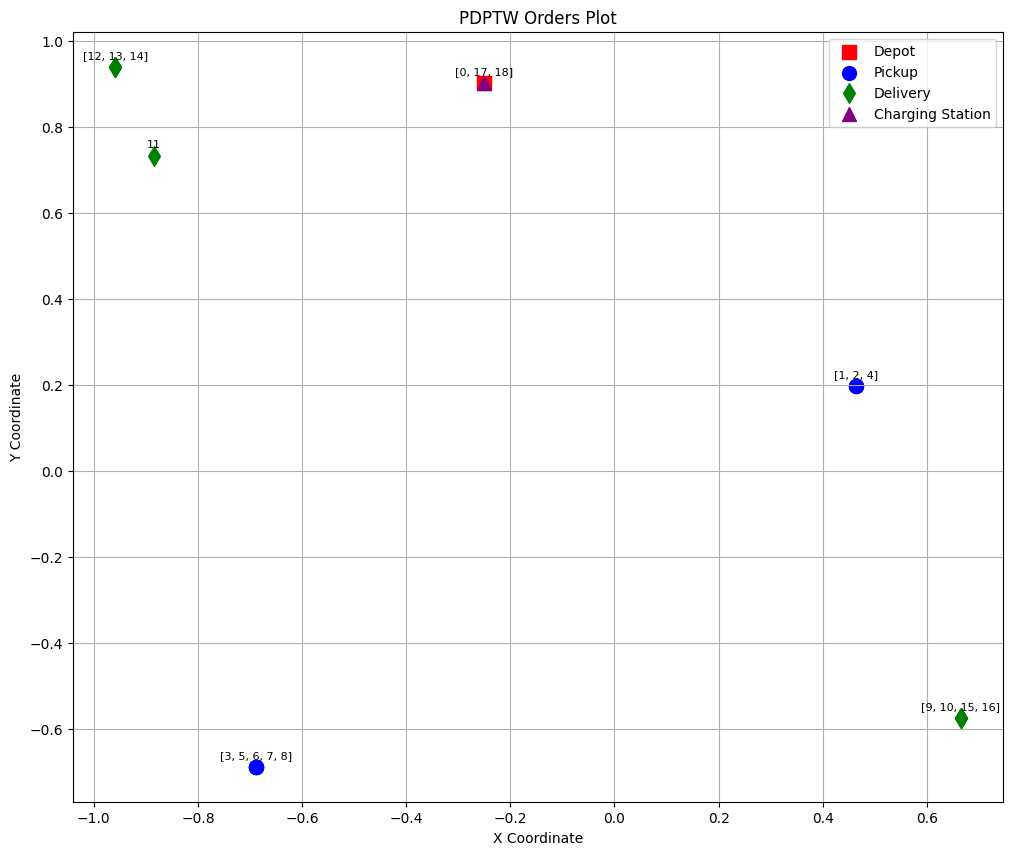

In [3]:
# Plot the instance with improved visualization
pdptw_order.plot_instance()

# solution

In [3]:
from instance import PDPTWInstance
from solvers import greedy_insertion_init, ALNS

pdptw_instance = PDPTWInstance(pdptw_order)
num_vehicles = 3
vehicle_capacity = 6
battery_capacity = 240
battery_consume_rate = 1
penalty_unvisited = 100
penalty_delayed = 5

# 使用贪心插入法生成初始解
initial_solution = greedy_insertion_init(pdptw_instance, num_vehicles, vehicle_capacity, 
                                         battery_capacity, battery_consume_rate, 
                                         penalty_unvisited, penalty_delayed)

print("Initial solution objective value:", initial_solution.objective_function())

Initial solution objective value: 37.473335162510466


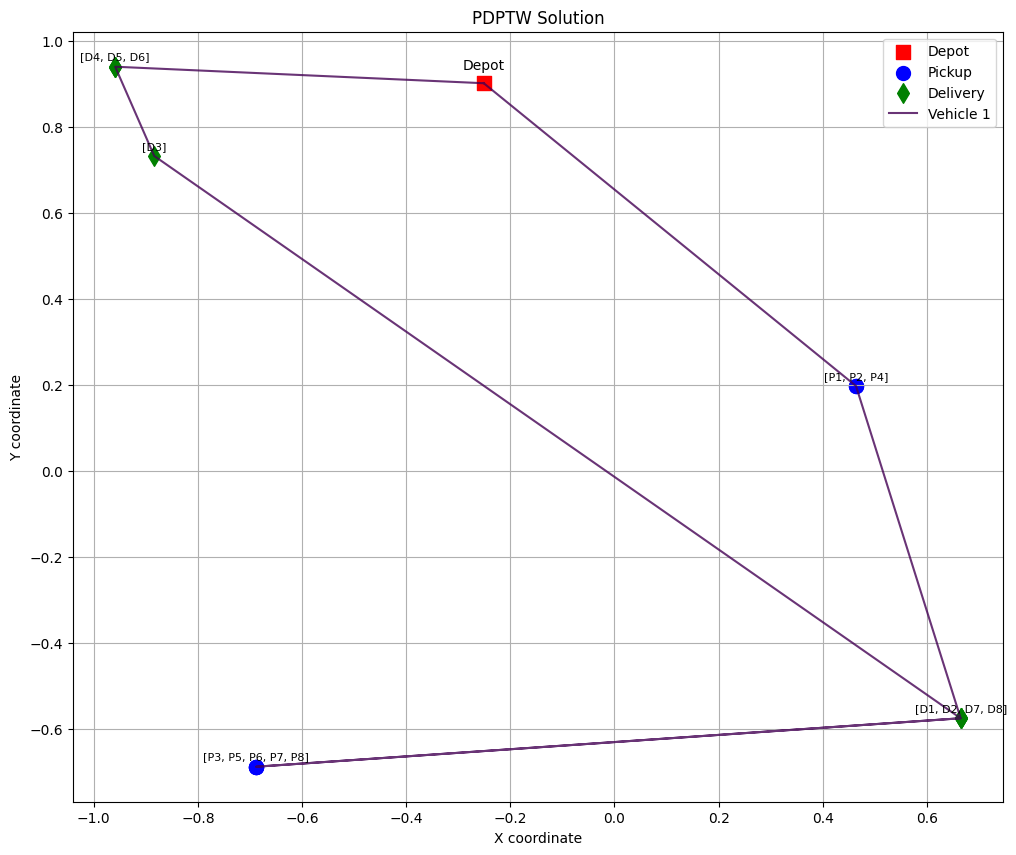

In [5]:
initial_solution.plot_solution()

In [ ]:
# sisr的前置参数
# 跑一下alns
# 你的battery relaxation
# battery swap

# ALL

In [3]:
from real_map import RealMap
from demands import DemandGenerator
from order_info import OrderGenerator
from instance import PDPTWInstance
from solvers import greedy_insertion_init, ALNS
import random
import numpy as np
import pandas as pd

 # Set random seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)


# Real map
n_r=2
n_c=4
dist_function=np.random.uniform
dist_params={'low': -1, 'high': 1}
## Create RealMap instance
realMap = RealMap(n_r, n_c, dist_function, dist_params)

# Demands
n_pairs = n_r*n_c # total number of restranuts-customer pairs
time_range=30
time_step=10
n_time_intervals = time_range/time_step # total number of time intervals
average_order = 10
random_params = {
    'sample_dist': {'function': np.random.randint, 'params': {'low': n_pairs-0.5, 'high': n_pairs}},
    'demand_dist': {'function': np.random.poisson, 'params': {'lam': average_order/(n_pairs)/n_time_intervals}}
    }
## Create demands
demands = DemandGenerator(time_range, time_step, restaurants=realMap.restaurants,
                         customers=realMap.customers, random_params=random_params)

# Order
time_params = {'time_window_length': 30, 
               'service_time': 2, 
               'extra_time': 10}
robot_speed = 4 # km/h
## Create Order info
pdptw_order = OrderGenerator(realMap, demands.demand_table, time_params, robot_speed)

# Instace
pdptw_instance = PDPTWInstance(pdptw_order)

# Solution
num_vehicles = 3
vehicle_capacity = 6
battery_capacity = 240
battery_consume_rate = 1
penalty_unvisited = 100
penalty_delayed = 5

# 使用贪心插入法生成初始解
initial_solution = greedy_insertion_init(pdptw_instance, num_vehicles, vehicle_capacity, 
                                         battery_capacity, battery_consume_rate, 
                                         penalty_unvisited, penalty_delayed)

print("Initial solution objective value:", initial_solution.objective_function())


Total number of orders: 23


,ID,Type,X,Y,Demand,StartTime,EndTime,ServiceTime,PartnerID,RealIndex,RealType
0,0,depot,-0.250920,0.901429,0,0.000000,inf,0,0,0,depot
1,1,cp,0.463988,0.197317,1,0.000000,inf,2,24,1,restaurant
2,2,cp,0.463988,0.197317,1,0.000000,inf,2,25,1,restaurant
3,3,cp,0.463988,0.197317,1,0.000000,inf,2,26,1,restaurant
4,4,cp,0.463988,0.197317,1,0.000000,inf,2,27,1,restaurant
5,5,cp,-0.687963,-0.688011,1,0.000000,inf,2,28,2,restaurant
6,6,cp,-0.687963,-0.688011,1,0.000000,inf,2,29,2,restaurant
7,7,cp,-0.687963,-0.688011,1,0.000000,inf,2,30,2,restaurant
8,8,cp,0.463988,0.197317,1,10.000000,inf,2,31,1,restaurant
9,9,cp,0.463988,0.197317,1,10.000000,inf,2,32,1,restaurant
